In [245]:
%load_ext autoreload
%autoreload 2

from data.simple_song import create_sin_wave, create_cos_wave, create_song, stack
import soundfile as sf
from scipy.fft import ifft, fft, fftfreq
import matplotlib.pyplot as plt
import numpy as np
from utils.constants import SAMPLE_RATE
from algorithms.action_elimination import action_elimination
from utils.constants import SAMPLE_RATE, SECONDS_PER_MINUTE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Human hearing is 16Hz to 32 KHz. Let's play around with Ultranumb by Blue Stahli

11713536


/Users/motiwari/opt/anaconda3/envs/mips/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


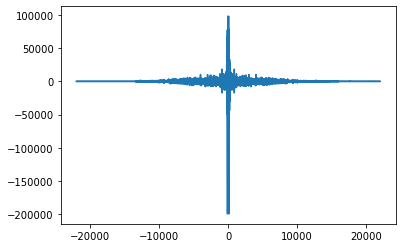

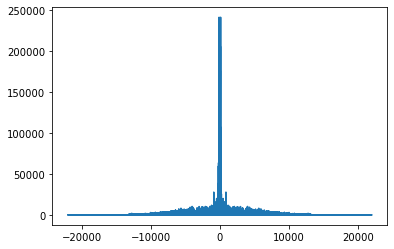

In [247]:
data, samplerate = sf.read('ultranumb.wav')
T = len(data)
print(T)

yf = fft(data)
xf = fftfreq(T, 1 / SAMPLE_RATE)

plt.plot(xf, yf)
plt.show()

plt.plot(xf, np.abs(yf))
plt.show()

In [232]:
fft(yf)

array([-9.31322575e-10+1.13686838e-10j,  2.18278728e-10+1.83149496e-10j,
       -1.45519152e-09+2.49201548e-10j, ...,
        0.00000000e+00+6.45101870e-10j, -6.98491931e-10+1.91871656e-10j,
        2.24099495e-09-8.82571403e-10j])

In [234]:
# Write the IFFT of the FFT to file. This should be the same as the original file, up to precision

sf.write('ultranumb_fft2.wav', np.real(ifft(yf)), SAMPLE_RATE)

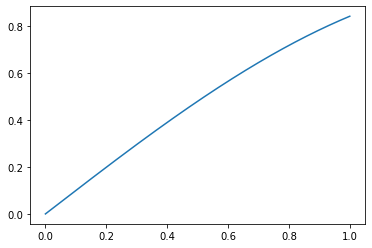

In [236]:
# 1/(2*pi) of a sine wave
plt.plot(np.arange(44100) / 44100, create_sin_wave(1, 44100, 44100)) 

In [237]:
frequencies = [1, 10, 100, 1000, 10000, 100000]
atoms = np.array([create_cos_wave(frequency_multiplier=f, sampling_frequency=SAMPLE_RATE, num_samples=T) for f in frequencies])

In [238]:
(atoms @ data) / len(data)

array([-3.27195559e-05,  2.58508651e-07, -6.83540363e-06,  3.29910755e-04,
       -1.42334472e-04,  6.21356813e-08])

In [239]:
data.shape

(11713536,)

In [240]:
print(np.argmax(np.abs(atoms @ data)), np.max(np.abs(atoms@data)))

3 3864.42150528176


In [241]:
stack(atoms, 10) @ stack(data, 10)

array([-3.83261696e+03,  3.02805039e+01, -8.00667465e+02,  3.86442151e+04,
       -1.66723996e+04,  7.27828540e+00])

In [243]:
# Run AE to identify the most present frequency in Ultranumb, stacked 10 times. Answer should be index 3
signals = data.reshape(1, -1)
action_elimination(stack(atoms, 10), stack(signals, 10), var_proxy = 1, epsilon=0, delta=0.01, abs=True, batch_size=100000)

[0 1 2 3 4 5]
1
[3.43957658e-04 5.65014549e-04 1.99474218e-04 1.79388532e-04
 2.41702527e-04 5.26618809e-05]
[-0.01096704 -0.01074598 -0.01111152 -0.01113161 -0.01106929 -0.01125833]
[0.01165495 0.01187601 0.01151047 0.01149038 0.0115527  0.01136366]


[0 1 2 3 4 5]
1
[4.52976350e-04 5.76841803e-04 2.54638107e-04 9.46051852e-05
 3.27847736e-04 4.13396059e-05]
[-0.0075451  -0.00742124 -0.00774344 -0.00790348 -0.00767023 -0.00795674]
[0.00845106 0.00857492 0.00825272 0.00809269 0.00832593 0.00803942]


[0 1 2 3 4 5]
0
[5.11062925e-04 3.53227591e-04 2.94755985e-04 8.33640683e-06
 7.55360444e-05 2.38609412e-05]
[-0.00601934 -0.00617718 -0.00623565 -0.00652207 -0.00645487 -0.00650654]
[0.00704147 0.00688363 0.00682516 0.00653874 0.00660594 0.00655427]


[0 1 2 3 4 5]
1
[2.13486135e-04 2.62788536e-04 3.58057598e-05 4.62945083e-05
 1.24946329e-04 7.73807542e-06]
[-0.00544201 -0.00539271 -0.00561969 -0.0056092  -0.00553055 -0.00564776]
[0.00586898 0.00591829 0.0056913  0.00570179 0.00578044 0.

KeyboardInterrupt: 

# Let's create a simple song

In [219]:
song = create_song(num_minutes=10)
#sf.write('A440.wav', song, SAMPLE_RATE)

In [248]:
signals = song.reshape(1, -1)

# Note: Need to use 2*\pi exactly here! Using 6.28 means that the waves won't go through
# full cycles each second, which means stacking them 10 times will give different answers from just continuing them
two_pi = 2*np.pi
frequencies = two_pi * np.array([256, 330, 392, 2*256, 2*330, 2*392])
atoms = np.array([create_sin_wave(frequency_multiplier=f, sampling_frequency=SAMPLE_RATE, num_samples=SAMPLE_RATE*SECONDS_PER_MINUTE*10) for f in frequencies])

# Identify the first component with AE. Should be index 2, i.e., G0
action_elimination(atoms, signals, var_proxy = 0.1, epsilon=0, delta=0.001, abs=True, batch_size=300)

[2]
2
[0.05791313 0.31776706 0.86232533 0.30219241 0.22805964 0.03176157]
[-0.01824248  0.24161145  0.78616972  0.2260368   0.15190403 -0.04439403]
[0.13406874 0.39392266 0.93848093 0.37834802 0.30421525 0.10791718]




(array([[2]]), array([1800]))

In [252]:
print(atoms @ signals.T)
print()
print((atoms @ signals.T) / 26460000)

[[6.61500000e+06]
 [1.32300000e+07]
 [3.96900000e+07]
 [1.65375000e+07]
 [9.92250000e+06]
 [3.04525862e-08]]

[[2.50000000e-01]
 [5.00000000e-01]
 [1.50000000e+00]
 [6.25000000e-01]
 [3.75000000e-01]
 [1.15089139e-15]]


In [253]:
# Check that we can stack the data and still get the same complexity
action_elimination(stack(atoms, 4), stack(signals, 4), var_proxy = 0.1, epsilon=0, delta=0.01, abs=True, batch_size=300)

[2]
2
[0.06109297 0.26060032 0.70166021 0.33816611 0.20048664 0.08924961]
[-0.00421109  0.19529626  0.63635615  0.27286206  0.13518259  0.02394556]
[0.12639702 0.32590437 0.76696427 0.40347017 0.2657907  0.15455367]




(array([[2]]), array([1800]))

In [259]:
# Let's delete G0 and run AE on the remainder to make sure we find C1, i.e., index 3
two_pi = 2 * np.pi
G0 = create_sin_wave(frequency_multiplier=392 * two_pi, sampling_frequency=SAMPLE_RATE,num_samples=SAMPLE_RATE * SECONDS_PER_MINUTE*10)
signal_G0_removed = signals - 3*G0

action_elimination(atoms, signal_G0_removed, var_proxy = 0.1, epsilon=0, delta=0.001, abs=True, batch_size=300)

[1 3 4]
1
[0.11179798 0.32381339 0.01026791 0.32155648 0.20673746 0.01302609]
[ 0.03564237  0.24765778 -0.06588769  0.24540087  0.13058185 -0.06312952]
[0.18795359 0.399969   0.08642352 0.39771209 0.28289307 0.0891817 ]


[1 3]
3
[0.11179798 0.34307976 0.01026791 0.44879034 0.26403904 0.01302609]
[ 0.03564237  0.28922962 -0.06588769  0.3949402   0.21018889 -0.06312952]
[0.18795359 0.39692991 0.08642352 0.50264049 0.31788918 0.0891817 ]


[3]
3
[0.11179798 0.37223093 0.01026791 0.5021315  0.26403904 0.01302609]
[ 0.03564237  0.32826247 -0.06588769  0.45816304  0.21018889 -0.06312952]
[0.18795359 0.41619939 0.08642352 0.54609996 0.31788918 0.0891817 ]




(array([[3]]), array([3300]))

# A reminder of the pain of substituting 6.28 for 2$\pi$

0.0
-1.7639370568305323e-11
0.04697590286782147
0.046999712164788904


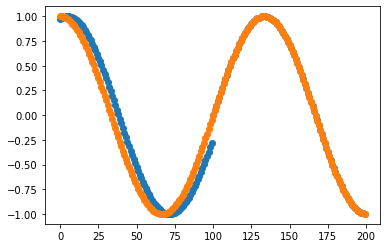

In [257]:
# Somehow sampling with 10x as many is different from stacking 10 times!!!
# Slight different in frequency because of 6.28 instead of 2*pi??? YES!!!

print(E0_10[2646000])
print(atoms[1][2646000])
print(E0_10[2646001])
print(atoms[1][2646001])

buffer = 100
plt.scatter(range(2*buffer), E0_10[2646000 - buffer:2646000 + buffer])
plt.scatter(range(2*buffer), atoms[1, 2646000 - buffer:2646000 + buffer])
plt.show()